In [1]:
from problem import get_train_data, get_test_data, WeightedClassificationError
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import sys
import tensorflow as tf
from time import time
import pandas as pd
import math
from tensorflow import keras
from tensorflow.keras import layers

## Datasets

In [2]:
videos_train, labels_train = get_train_data()

In [3]:
X_for_classifier= np.array(videos_train)
y_for_classifier= labels_train

In [7]:
videos_test, labels_test  = get_test_data()

In [8]:
Xtest_for_classifier = np.array(videos_test)
ytest_for_classifier = labels_test

In [9]:
from PIL import Image

def resize_frames(video):
    res=[]
    for frame in video:
        resized_img=Image.fromarray(frame).resize((224,224))
        res.append(np.array(resized_img))
    return np.array(res)

In [10]:
#function that gets all dataset
# 30 frames per video for 177 video = 2.65 gb !if considering each frame of float64
# as uint8 it takes 0.33 gb

def gen_videos(videolist):
    newvideos=[] # 177*30*250*250
    for video in videolist:
        reducedvideo= video.read_samples(video.frame_times[0:299:10])
        #resize from 250 to 224
        reducedvideo=resize_frames(reducedvideo)    

        newvideos.append(reducedvideo)
    return newvideos

In [11]:
X_for_classifier= np.array(gen_videos(X_for_classifier))
X_for_classifier = np.repeat(X_for_classifier[...,np.newaxis], 3, -1)

X_for_classifier.shape

(177, 30, 224, 224, 3)

In [12]:
Xtest_for_classifier= np.array(gen_videos(Xtest_for_classifier))
Xtest_for_classifier = np.repeat(Xtest_for_classifier[...,np.newaxis], 3, -1)

Xtest_for_classifier.shape

(100, 30, 224, 224, 3)

## Tools

In [13]:
def class_to_int(argument):
    switcher = {
        'A':0,
        'B':1,
        'C':2,
        'D':3,
        'E':4,
        'F':5,
        'G':6,
        'H':7,
    }
    return switcher.get(argument, "nothing")

def int_to_class(argument):
    switcher = {
        0:'A',
        1:'B',
        2:'C',
        3:'D',
        4:'E',
        5:'F',
        6:'G',
        7:'H',
    }
    return switcher.get(argument, "nothing")


func=np.vectorize(class_to_int)
#Train
train_labels=func(y_for_classifier)
#Test
test_labels=func(ytest_for_classifier)

## Feature extractor

In [14]:
# Builds the MobileNetV2 based feature extractor that will be applied to every frame

def build_extractor():
    # Image shape for classifier
    IMG_SHAPE = (224,224,3)

    # Building of a classification model
    feature_extractor = tf.keras.applications.MobileNetV2(
            input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
        )
    feature_extractor.trainable = False
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    #prediction_layer = tf.keras.layers.Dense(8, activation="softmax")
    
    x = preprocess_input(inputs)
    x = feature_extractor(x, training=False)
    
    x = global_average_layer(x)
    outputs = tf.keras.layers.Dropout(0.2)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["sparse_categorical_accuracy"],
    )
    return model

In [15]:
feature_extractor=build_extractor()

In [16]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

### Feature extraction example

In [17]:
X_for_classifier.shape

(177, 30, 224, 224, 3)

In [18]:
X_for_classifier[1][1][None,:,:].shape

(1, 224, 224, 3)

In [19]:
# Feature extraction example:
example= X_for_classifier[1][1][None,:,:,:]
f1=feature_extractor.predict(example)

1/1 [==============================] - 3s 3s/step


In [20]:
np.squeeze(f1).shape

(1280,)

In [21]:
f1.max() #min is 0

3.8005023

## Extracting features of the train and test dataset

In [22]:
pred_times = [27, 32, 37, 40, 44, 48, 53, 58, 63, 94, None]

In [23]:
#hardcoding the frames selected. In reality the frame corresponding to a pred time varies from vid to vid as t0 varies.
def timeToFrame(argument):
    switcher = {
        27: 0,
        32:2,
        37:5,
        40:8,
        44:11,
        48:14,
        53:17,
        58:20,
        63:23,
        94:26,
        None: 29
    }
    return switcher.get(argument, "nothing")
    

In [24]:
def extract_features(dataset, predtime):
    n= timeToFrame(predtime)
    #extracting the f map
    featmap=[]
    for i in range(dataset.shape[0]):  # num of videos in ds
        f1=feature_extractor.predict(dataset[i][n][None,:,:], verbose='false') # ith video, nth frame
        featmap.append(f1)
    return featmap

### example for the 300th frame

In [25]:
train_featmap300= extract_features(X_for_classifier,None)

In [26]:
np.array(train_featmap300).shape

(177, 1, 1280)

## Building the 11 models

In [28]:
pred_times = [27, 32, 37, 40, 44, 48, 53, 58, 63, 94, None]

In [29]:
def build_11_models():
    models=[]
    for time in pred_times:
        fmap=extract_features(X_for_classifier, time)
        X_train= np.array(fmap).squeeze()
        y_train=np.array(train_labels)
        # defining the classifier
        lr = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
        lr.fit(X_train, y_train)
        
        models.append(lr)
    return models

In [30]:
models= build_11_models()

In [31]:
np.array(models).shape

(11,)

## Testing the 11 models

In [32]:
test_fmaps=[]
for time in pred_times:
    testfmap=extract_features(Xtest_for_classifier, time)
    test_fmaps.append(testfmap)

In [33]:
np.array(test_fmaps).shape

(11, 100, 1, 1280)

In [34]:
pred_probas=[]
for i in range(11):
    
    X_test= np.array(test_fmaps[i]).squeeze()
    Y_test= np.array(test_labels)
    
    predproba=models[i].predict_proba(X_test)
    pred_probas.append(predproba)

In [35]:
for time_idx, my_pred_time in enumerate(pred_times):
    print(time_idx, my_pred_time)

0 27
1 32
2 37
3 40
4 44
5 48
6 53
7 58
8 63
9 94
10 None


In [36]:
np.array(pred_probas[0]).shape

(100, 8)

In [77]:
wces=[]
for i in range(11):
    wce = WeightedClassificationError(time_idx=i)
    res= wce.compute(y_true=test_labels, y_pred=pred_probas[i])
    wces.append(res)

In [78]:
for i, wce in enumerate(wces):
    print(f"WCE at time {i}: {wce}")

WCE at time 0: 0.6940000000000001
WCE at time 1: 0.7020000000000001
WCE at time 2: 0.7190000000000001
WCE at time 3: 0.665
WCE at time 4: 0.6559999999999999
WCE at time 5: 0.7190000000000001
WCE at time 6: 0.6780000000000002
WCE at time 7: 0.687
WCE at time 8: 0.696
WCE at time 9: 0.674
WCE at time 10: 0.627


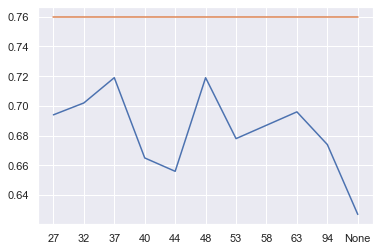

In [86]:
ys = wces
xs = ['27', '32', '37', '40', '44', '48', '53', '58', '63', '94', 'None']
s=[0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76]

plt.plot(xs, ys)
plt.plot(xs,s)
plt.show()

plt.close()